# Capstone Project - The Battle of neighborhoods

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French, etc.

So the objective of this project is to list and visualize all major parts of New York City that have great Indian restaurants.

### Data 
#### New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
 
Data source : https://cocl.us/new_york_dataset

Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
 
#### Indian restaurants in each neighborhood of new york city.
        
Data source : Foursquare API

Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Indian restaurants.
     
#### GeoSpace data
        
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Indian Restaurants.
- Find rating, tips and like count for each Indian Resturants using FourSquare API.
- Using rating for each resturant, we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Results

The results are carried out to give the answer of the following questions:

What is the best location in New York City for Indian Cuisine?

Which areas have a  potential Indian Restaurant Market?

Which are some of the best neighborhoods for Indian cuisine?

Which is the best place to stay if you prefer Indian Cuisine?

##### Analysis is done with required python libraries

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [18]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   # CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = '4IHGX34AAOMXD14JMF2Y1AWXISOVL4OW0QV2EBUNBLS2IAWF' 
    CLIENT_SECRET = '1ZMVX20KHBV4CKG12J5CCHE4WOENR3EUCS0YFXALLM3SJAHE' 
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
def get_venue_details(venue_id):
        
    #CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = '4IHGX34AAOMXD14JMF2Y1AWXISOVL4OW0QV2EBUNBLS2IAWF' 
    CLIENT_SECRET = '1ZMVX20KHBV4CKG12J5CCHE4WOENR3EUCS0YFXALLM3SJAHE' 
    VERSION = '20180604'
    #LIMIT = 30
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
# get new york data
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

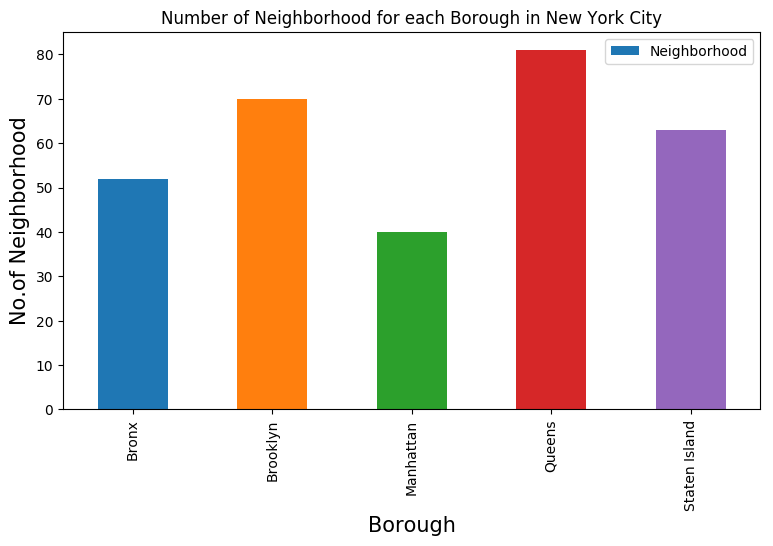

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()



#### collect Indian resturants for each Neighborhood


In [19]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

KeyError: 'groups'

In [20]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
3,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
4,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [21]:
indian_rest_ny.shape

(36, 4)

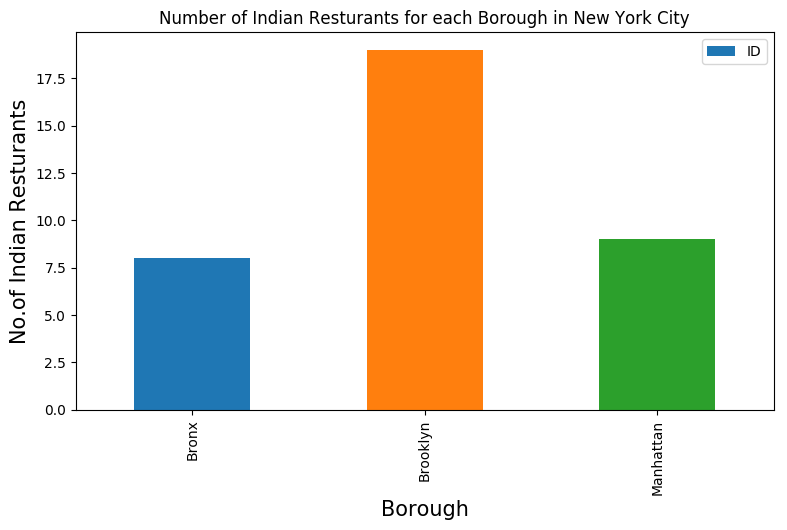

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


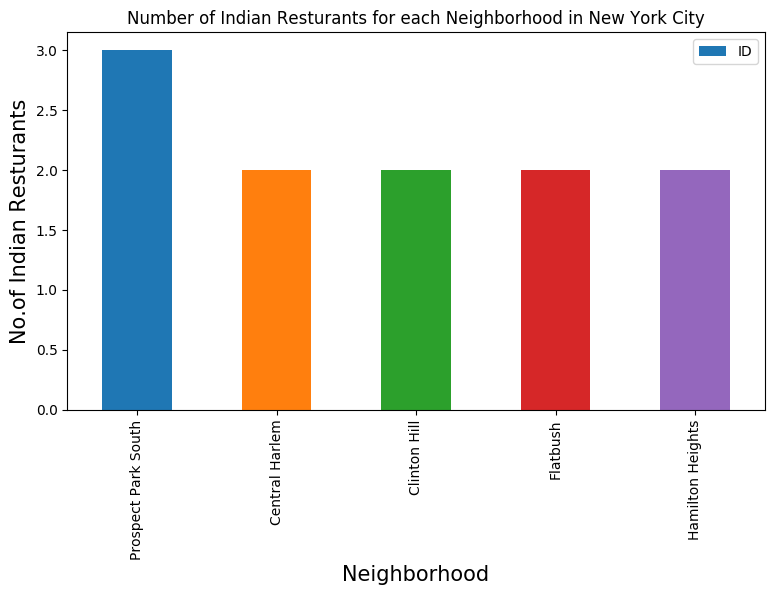

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [33]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Prospect Park South']

,Borough,Neighborhood,ID,Name
22,Brooklyn,Prospect Park South,519ff6c8498e1300ddcbd45c,Anarkali Indian Cuisine
23,Brooklyn,Prospect Park South,4db0f4371e729fcc56497f20,Mashallah
24,Brooklyn,Prospect Park South,4b718914f964a520c04b2de3,Madina Restaurant and Sweets


Thus Prospect Park South in Brooklyn has highest number of restaurants i.e 3

In [34]:
# get the ranking of each resturant for further analysis.
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 1 / 36 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 2 / 36 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     7.8    11
( 3 / 36 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 570c3a3fcd10eecd0d0434cd
( 4 / 36 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 36 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 6 / 36 ) processed
                         ID         Name  Likes  Rat

In [35]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.8,11
3,Bronx,Williamsbridge,0,0,0,0.0,0
4,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [36]:
indian_rest_stats_ny.shape

(36, 7)

In [37]:
indian_rest_ny.shape

(36, 4)

In [38]:
# save data to csv
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [39]:
# Verify csv data
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

(36, 7)

In [40]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.8,11
3,Bronx,Williamsbridge,0,0,0,0.0,0
4,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [41]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
Borough         36 non-null object
Neighborhood    36 non-null object
ID              36 non-null object
Name            36 non-null object
Likes           36 non-null object
Rating          36 non-null float64
Tips            36 non-null object
dtypes: float64(1), object(6)
memory usage: 2.0+ KB


In [42]:
# Need certain Preprocessing
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [43]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
Borough         36 non-null object
Neighborhood    36 non-null object
ID              36 non-null object
Name            36 non-null object
Likes           36 non-null float64
Rating          36 non-null float64
Tips            36 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.0+ KB


In [44]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Yorkville
ID              5272ca4511d22488f6895caf
Name                      Drunken Munkey
Likes                                207
Rating                               8.5
Tips                                  61
Name: 35, dtype: object

In [45]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 73
Rating                               8.7
Tips                                  22
Name: 15, dtype: object

In [46]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                   Yorkville
ID              5272ca4511d22488f6895caf
Name                      Drunken Munkey
Likes                                207
Rating                               8.5
Tips                                  61
Name: 35, dtype: object

In [47]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [48]:
# The top neighborhoods with top average rating of Indian resturants

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
8,Fort Greene,8.70
13,North Side,8.50
19,South Side,8.50
25,Yorkville,8.50
0,Bay Ridge,8.30
3,Clinton Hill,8.25
5,East Flatbush,8.20
2,Central Harlem,8.10
14,Ocean Hill,8.05
16,Prospect Lefferts Gardens,7.95


In [60]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [61]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.833333
1,Brooklyn,7.821053
0,Bronx,5.737500


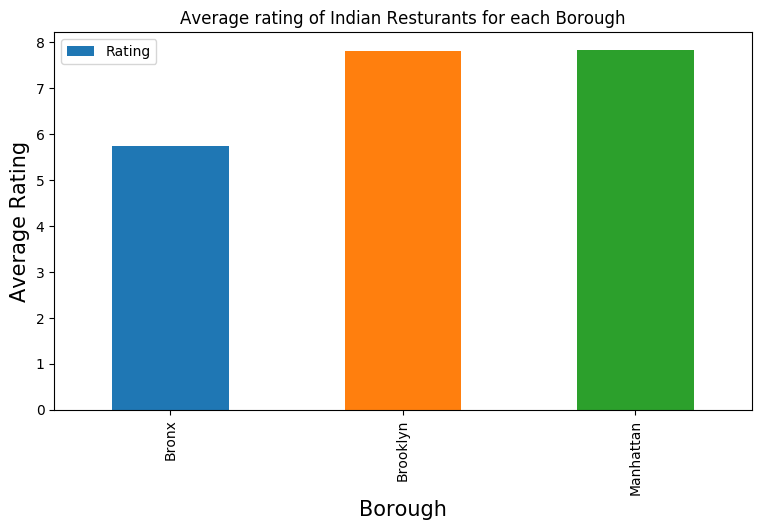

In [49]:
# Visualization
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [50]:
#consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]


In [51]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,8.30
2,Central Harlem,8.10
3,Clinton Hill,8.25
5,East Flatbush,8.20
8,Fort Greene,8.70
13,North Side,8.50
14,Ocean Hill,8.05
19,South Side,8.50
25,Yorkville,8.50


In [52]:
#join this dataset to original new york data to get lonitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [53]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.30
1,Manhattan,Central Harlem,40.815976,-73.943211,8.10
2,Brooklyn,Clinton Hill,40.693229,-73.967843,8.25
3,Brooklyn,East Flatbush,40.641718,-73.936103,8.20
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.70
5,Brooklyn,North Side,40.714823,-73.958809,8.50
6,Brooklyn,Ocean Hill,40.678403,-73.913068,8.05
7,Brooklyn,South Side,40.710861,-73.958001,8.50
8,Manhattan,Yorkville,40.775930,-73.947118,8.50


In [54]:
# Display data on map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [55]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [56]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [57]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Discussion
The analysis has been carried out to list and visualize all major parts of New York City that has great indian resturants. The restaurant with varous attribues like  maximum likes, rating and tips is also provided. The accuracy of data is  completely depends on the data provided by FourSquare.

### Conclusion

1. Brooklyn has the largest  number of Indian Resturants.

2. The Prospect Park South in Brooklyn has the highest number of restaurants i.e 3.

3. Bay Ridge (Brooklyn), Central Harlem (Manhattan), Clinton Hill (Brooklyn) are some of the best neighborhoods for indian cuisine.

4. Manhattan and Brooklyn are the best places to stay if you prefer Indian Cuisine. Though Manhattan ranks first and Brooklyn ranks second in ranking ; the difference in their average rating is minimal i.e Manahtten is with 7.83 and Brooklyn is with 7.82.

